In [1]:
import pandas as pd
import numpy as np
from numpy.random import random
import scipy
import scipy.stats as st
from scipy import interpolate

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from copy import copy
import networkx as nx


from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('transactions.csv')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head()

(27675, 14)


,isFraud,TransactionDT,TransactionAmt,D1,D2,D3,card1,card2,card3,addr1,addr2,V104,V105,V106
0,0,86821,73.95,66.0,66.0,35.0,10112,360.0,150.0,264.0,87.0,0.0,0.0,0.0
1,0,87135,107.95,245.0,245.0,245.0,17359,555.0,150.0,469.0,87.0,0.0,0.0,0.0
2,0,87611,250.00,238.0,32.0,0.0,3278,453.0,150.0,122.0,87.0,0.0,0.0,0.0
3,0,88053,107.00,57.0,57.0,56.0,14165,111.0,150.0,181.0,87.0,0.0,0.0,0.0
4,0,88149,159.00,40.0,40.0,9.0,6459,100.0,150.0,325.0,87.0,0.0,0.0,0.0


### Step 1. Choose variables for sampling from your dataset (overall – about 10 variables, 3-4 – target variables, the rest - predictors).

In [3]:
targets = ['TransactionAmt',  'D1', 'card1']
predictors = ['D2', 'D3', 'card2', 'card3', 'addr1', 'addr2', 'V104', 'V105', 'V106']

df = df[targets + predictors]
df.dropna(inplace=True)

### Step 2. Using univariate parametric distributions that were fitted in Lab#2 make sampling of chosen target variables. Use for this 2 different sampling methods.

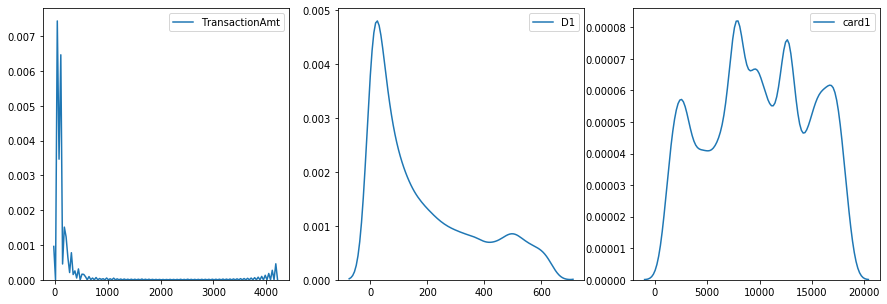

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(df[targets[0]], ax=axes[0]);
sns.kdeplot(df[targets[1]], ax=axes[1]);
sns.kdeplot(df[targets[2]], ax=axes[2]);

In [5]:
def best_fit_distribution(data, bins=200, ax=None):
    y, x = np.histogram(data, bins=bins, density=True, normed = True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    DISTRIBUTIONS = [        
        st.dgamma,st.expon, st.exponnorm, st.gamma, st.laplace,st.levy, 
        st.logistic, st.lognorm, st.norm,st.pareto,st.pearson3,st.powerlaw,
        st.weibull_min
    ]

    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    for distribution in DISTRIBUTIONS:
        params = distribution.fit(data)

        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y - pdf, 2.0))

        if best_sse > sse > 0:
            best_distribution = distribution
            best_params = params
            best_sse = sse

    return best_distribution.name, best_params

In [6]:
%%time
dists = []
for target_name in targets:
    df_ = df[target_name]
    target_values = df_[df_ < np.percentile(df_, 95)]
    dist_name, params = best_fit_distribution(target_values)
    dists.append({'target_name': target_name, 'params': params, 
                  'dist': getattr(st, dist_name), 'dist_name': dist_name})

CPU times: user 7.16 s, sys: 0 ns, total: 7.16 s
Wall time: 7.16 s


In [7]:
dists

[{'target_name': 'TransactionAmt',
  'params': (9.173195152412376, 24.416273883876237, 7.764855504002455),
  'dist': <scipy.stats._continuous_distns.exponnorm_gen at 0x7f46c0ec5290>,
  'dist_name': 'exponnorm'},
 {'target_name': 'D1',
  'params': (0.7292361826985938, -6.199472512877553e-24, 168.65176149957466),
  'dist': <scipy.stats._continuous_distns.gamma_gen at 0x7f46c0e7c550>,
  'dist_name': 'gamma'},
 {'target_name': 'card1',
  'params': (1.0834616615529562, 1015.8168849171866, 16343.183115118201),
  'dist': <scipy.stats._continuous_distns.powerlaw_gen at 0x7f46c0e4d710>,
  'dist_name': 'powerlaw'}]

In [8]:
def its_function(dist, params, size):
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    x = np.linspace(start, end, size)
    y = dist.pdf(x, *params)

    cdf_y = dist.cdf(x, *params)
    cdf_y = cdf_y/cdf_y.max()

    return interpolate.interp1d(cdf_y,x, fill_value="extrapolate")

def its(dist, params, N=10000):
    uniform_samples = random(int(N))
    inverse_cdf = its_function(dist, params, N)
    samples = inverse_cdf(uniform_samples)
    return samples

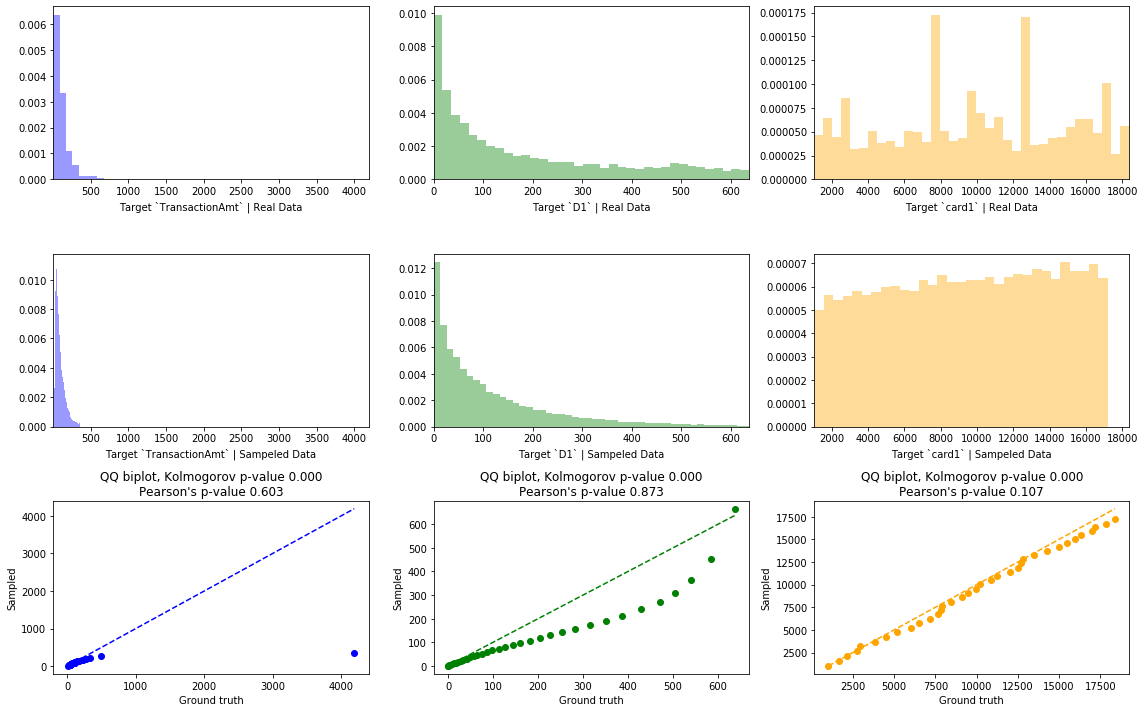

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
colors=['b', 'g', 'orange']

for i, dist in enumerate(dists):
    target_name = dist['target_name']

    samples = its(dist['dist'], dist['params'], N=len(df))
    n_bins = int(1 + (3.322 * np.log(len(df))).round())
    ks_stat, ks_pv = scipy.stats.ks_2samp(df[target_name], samples)
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(df[target_name], percs)
    qn_sampled = np.percentile(samples, percs)
    p_stat, p_pv = scipy.stats.pearsonr(df[target_name], samples)

    axes[0, i].set_xlim(df[target_name].min(), df[target_name].max())
    axes[1, i].set_xlim(df[target_name].min(), df[target_name].max())
    axes[2, i].set_xlabel("Ground truth")
    axes[2, i].set_ylabel("Sampled")
    axes[2, i].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.3f}\nPearson's p-value {p_pv:.3f}")


    sns.distplot(df[target_name], ax=axes[0, i], color=colors[i],
                 norm_hist=True, hist=True, kde=False, axlabel=f'Target `{target_name}` | Real Data')
    sns.distplot(samples, ax=axes[1, i], color=colors[i],
                 norm_hist=True, hist=True, kde=False, axlabel=f'Target `{target_name}` | Sampeled Data')
    axes[2, i].plot(qn_gt, qn_sampled, color=colors[i], ls="", marker="o", markersize=6)
    axes[2, i].plot(qn_gt, qn_gt, color=colors[i], ls="--")

    fig.tight_layout()

In [10]:
# Geometric (Neiman) method of sampling using histograms
def geom_sampling_hist(values, N=1000, batch_size=1000):
    n_bins = int(1 + (3.322 * np.log(values.shape[0])).round())
    
    hist, bin_edges = np.histogram(values, bins=n_bins, density=True)
    
    left, right = np.min(bin_edges), np.max(bin_edges)
    bottom, top = np.min(hist), np.max(hist)
    
    accept_samples = np.asarray([])
    
    while accept_samples.shape[0] < N:
        x_sampl = np.random.uniform(left, right, size=(batch_size,))
        y_sampl = np.random.uniform(bottom, top, size=(batch_size,))
        
        x_indices = np.digitize(x_sampl, bin_edges) - 1
        y_mask = (y_sampl <= hist[x_indices])
        
        accept_samples = np.concatenate([accept_samples, x_sampl[y_mask]])
        
    return accept_samples[:N], n_bins

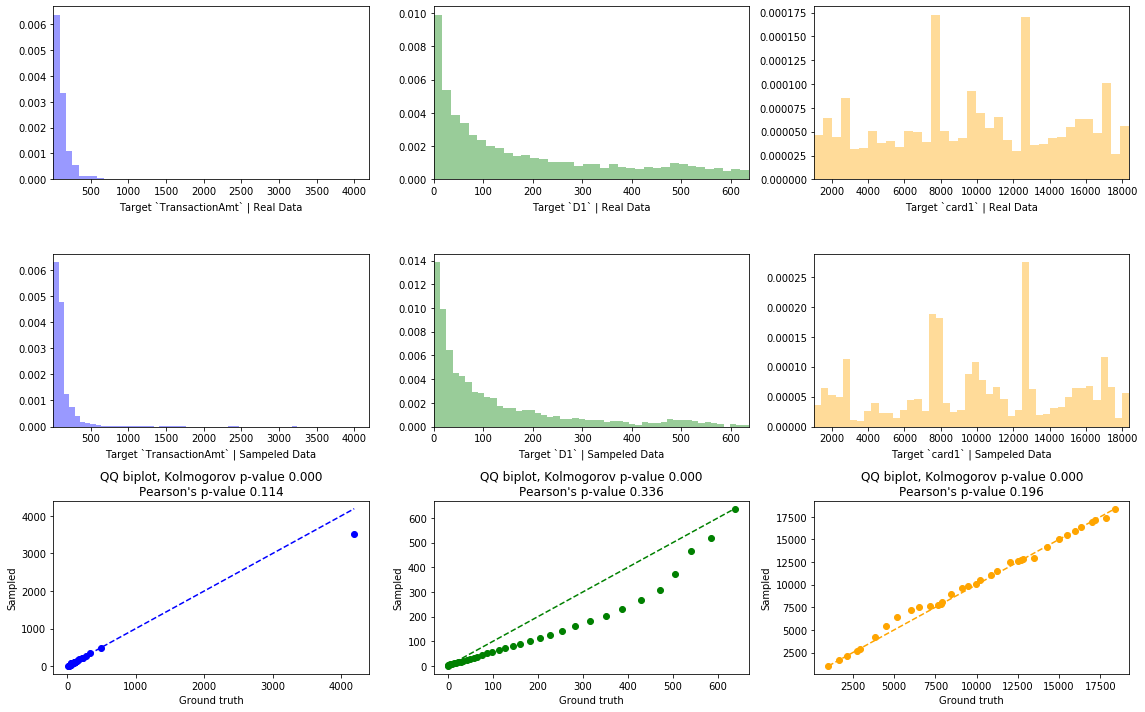

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
colors=['b', 'g', 'orange']

for i, target_name in enumerate(targets):
    samples, _ = geom_sampling_hist(df[target_name], N=len(df))

    n_bins = int(1 + (3.322 * np.log(len(df))).round())
    ks_stat, ks_pv = scipy.stats.ks_2samp(df[target_name], samples)
    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(df[target_name], percs)
    qn_sampled = np.percentile(samples, percs)
    p_stat, p_pv = scipy.stats.pearsonr(df[target_name], samples)

    axes[0, i].set_xlim(df[target_name].min(), df[target_name].max())
    axes[1, i].set_xlim(df[target_name].min(), df[target_name].max())
    axes[2, i].set_xlabel("Ground truth")
    axes[2, i].set_ylabel("Sampled")
    axes[2, i].set_title(f"QQ biplot, Kolmogorov p-value {ks_pv:.3f}\nPearson's p-value {p_pv:.3f}")

    sns.distplot(df[target_name], ax=axes[0, i], color=colors[i],
                 norm_hist=True, hist=True, kde=False, axlabel=f'Target `{target_name}` | Real Data')
    sns.distplot(samples, ax=axes[1, i], color=colors[i],
                 norm_hist=True, hist=True, kde=False, axlabel=f'Target `{target_name}` | Sampeled Data')
    axes[2, i].plot(qn_gt, qn_sampled, color=colors[i], ls="", marker="o", markersize=6)
    axes[2, i].plot(qn_gt, qn_gt, color=colors[i], ls="--")

    fig.tight_layout()

### Step 3. Estimate relations between predictors and chosen target variables. At least, they should have significant correlation coefficients.

`'TransactionAmt', 'D1', 'card1'` - targets,  
`'D2', 'D3', 'card2', 'card3', 'addr1', 'addr2', 'V104', 'V105', 'V106'` - predictors

In [12]:
correlation = df.corr().iloc[:3, 3:]
correlation

,D2,D3,card2,card3,addr1,addr2,V104,V105,V106
TransactionAmt,-0.017689,0.021551,0.019309,-0.022231,-0.010733,0.024206,0.007838,-0.003369,-0.001621
D1,0.980939,0.239783,0.031208,-0.009846,0.007111,0.021801,-0.054323,-0.052238,-0.056357
card1,-0.014170,-0.005636,0.007038,-0.001914,0.025615,0.002309,0.079449,0.082320,0.084397


Rough check for significance

In [13]:
abs(correlation) > 0.9

,D2,D3,card2,card3,addr1,addr2,V104,V105,V106
TransactionAmt,False,False,False,False,False,False,False,False,False
D1,True,False,False,False,False,False,False,False,False
card1,False,False,False,False,False,False,False,False,False


### Step 4. Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [14]:
edges = {
    "TransactionAmt": ["D3", "card3", "addr2"],
    "D1": ["D2", "D3", "addr2"],
    "card1": ["addr1", "V104", "V105", "V106"],
}

edges_list = []
for out_var, in_vars in edges.items():
    for in_var in in_vars:
        edges_list.append((out_var, in_var))

edges_list

[('TransactionAmt', 'D3'),
 ('TransactionAmt', 'card3'),
 ('TransactionAmt', 'addr2'),
 ('D1', 'D2'),
 ('D1', 'D3'),
 ('D1', 'addr2'),
 ('card1', 'addr1'),
 ('card1', 'V104'),
 ('card1', 'V105'),
 ('card1', 'V106')]

In [15]:
transformed_data = copy(df)
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(df)
transformed_data = pd.DataFrame(data_discrete, columns=df.columns)
transformed_data.head()

,TransactionAmt,D1,card1,D2,D3,card2,card3,addr1,addr2,V104,V105,V106
0,0.0,0.0,2.0,0.0,1.0,2.0,2.0,1.0,4.0,0.0,0.0,0.0
1,0.0,2.0,4.0,2.0,3.0,4.0,2.0,4.0,4.0,0.0,0.0,0.0
2,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,4.0,0.0,0.0,0.0
3,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,4.0,0.0,0.0,0.0


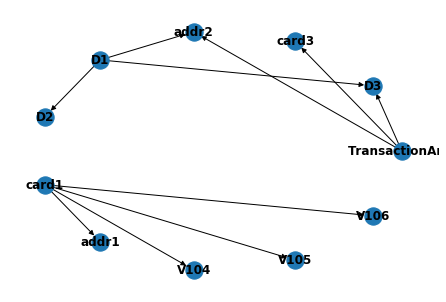

In [16]:
network1 = BayesianModel(edges_list)

G_MAN = nx.DiGraph()
G_MAN.add_edges_from(network1.edges())
pos = nx.layout.circular_layout(G_MAN)
nx.draw(G_MAN, pos, with_labels=True, font_weight='bold')

In [17]:
k2_scores = {}

k2_scores["manual"] = K2Score(transformed_data).score(network1)
print(f"K2 score of manual model: {K2Score(transformed_data).score(network1):.2f}")
print(f"BIC score of manual model: {BicScore(transformed_data).score(network1):.2f}")

K2 score of manual model: -173273.35
BIC score of manual model: -173595.02


In [18]:
def sampling(bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

In [19]:
df_s1 = sampling(network1, transformed_data, n=2000)

Generating for node: D3: 100%|██████████| 11/11 [00:00<00:00, 187.86it/s]  


### Step 5. Build a Bayesian network for the same set of variables but using 2 chosen algorithms for structural learning.

In [20]:
hc = HillClimbSearch(transformed_data, scoring_method=K2Score(transformed_data))
best_model = hc.estimate()

  0%|          | 19/1000000 [00:02<37:10:32,  7.47it/s]


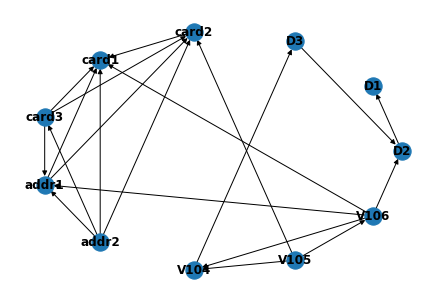

In [21]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [22]:
k2_scores["HillClimbSearch_k2"] = K2Score(transformed_data).score(best_model)

print(f"K2 score of HillClimbSearch K2: {K2Score(transformed_data).score(best_model):.2f}")
print(f"BIC score of HillClimbSearch K2: {BicScore(transformed_data).score(best_model):.2f}")

K2 score of HillClimbSearch K2: -212130.97
BIC score of HillClimbSearch K2: -291605.87


In [23]:
df_HillClimbSearch_k2 = sampling(best_model, transformed_data, n=2000)

Generating for node: card1: 100%|██████████| 11/11 [00:00<00:00, 25.99it/s]


In [24]:
hc_BicScore = HillClimbSearch(transformed_data, scoring_method=BicScore(transformed_data))
best_model_BicScore = hc_BicScore.estimate()

  0%|          | 20/1000000 [00:02<38:18:58,  7.25it/s]


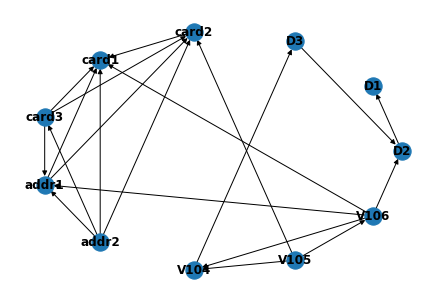

In [25]:
G_BicScore = nx.DiGraph()
G_BicScore.add_edges_from(best_model_BicScore.edges())
pos = nx.layout.circular_layout(G_BicScore)
nx.draw(G_BicScore, pos, with_labels=True,font_weight='bold')

In [26]:
k2_scores["HillClimbSearch_"] = K2Score(transformed_data).score(best_model_BicScore)

print(f"K2 score of HillClimbSearch {K2Score(transformed_data).score(best_model_BicScore):.2f}")
print(f"BIC score of HillClimbSearch {BicScore(transformed_data).score(best_model_BicScore):.2f}")

K2 score of HillClimbSearch -212130.97
BIC score of HillClimbSearch -291605.87


In [27]:
df_HillClimbSearch_k2 = sampling(best_model, transformed_data, n=2000)

Generating for node: card1: 100%|██████████| 11/11 [00:00<00:00, 26.90it/s]


### Step 5

In [28]:
def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()

In [29]:
sample_Bic = sampling(best_model_BicScore, transformed_data, 10000)

Generating for node: card1: 100%|██████████| 11/11 [00:00<00:00, 16.26it/s]


In [30]:
# sample_Bic = est.inverse_transform(sample_Bic.values)
sample_Bic = pd.DataFrame(sample_Bic, columns=df.columns)

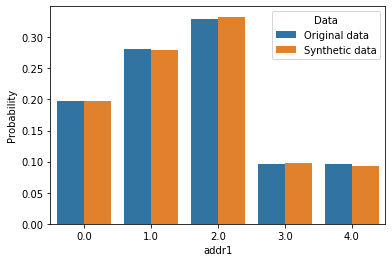

In [31]:
draw_comparative_hist('addr1', transformed_data, sample_Bic)

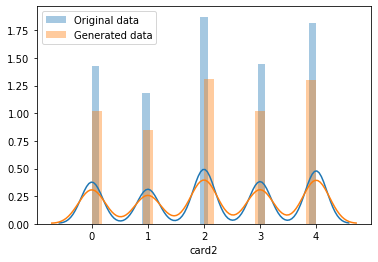

In [32]:
sns.distplot(transformed_data['card2'], label='Original data')
sns.distplot(sample_Bic['card2'], label='Generated data')
plt.legend()

In [33]:
sample_k2 = sampling(best_model, transformed_data, 10000)

Generating for node: card1: 100%|██████████| 11/11 [00:00<00:00, 16.61it/s]


In [34]:
# sample_k2 = est.inverse_transform(sample_k2.values)
sample_k2 = pd.DataFrame(sample_k2, columns=df.columns)

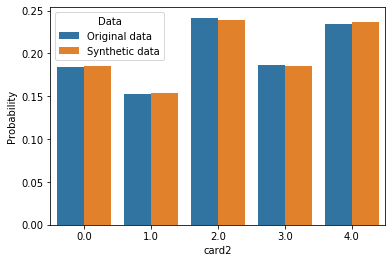

In [35]:
draw_comparative_hist('card2',transformed_data, sample_ Bic)

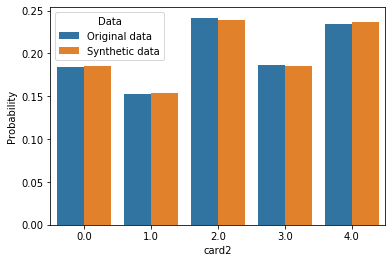

In [36]:
draw_comparative_hist('card2',transformed_data, sample_Bic)

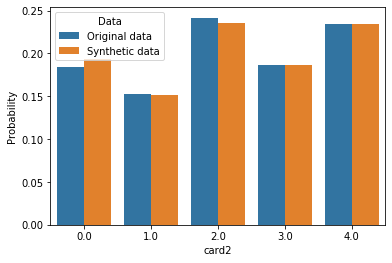

In [37]:
draw_comparative_hist('card2',transformed_data, sample_k2)